In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import os
import numpy as np
import json

In [45]:
#Matplotlib defaults (eventually)
plt.rcParams.update({'font.size': 22})

# Step 1: Build data structures

See pg 116 in notebook

* Dataframe, organized by individual patent-author / patent-assignee combinations (with appropriate tags)
    - in Data/Patents/patent_MA_results.csv
* Dictionary linking patents to a list of cpds associated with it
    - in Data/Patents/patent_cpds_links.p
* Dictionary linking patents to a list of MA values associated with it
* Dictionary linking patents to classifications

In [3]:
## Patent/classification dictionary
author_df = pd.read_csv("Data/Patents/patent_author_records.csv")
assignee_df = pd.read_csv("Data/Patents/patent_assignee_records.csv")

In [6]:
#Do author/assignees have different patent ids?

author_ids = list(set(list(author_df["ID"])))
assignee_ids = list(set(list(assignee_df["ID"])))

print(len(author_ids))
print(len(assignee_ids))

print(len(set(author_ids) - set(assignee_ids))) #This should be 0...

744686
332467
660634


In [7]:
patent_classifications = dict(zip(author_df.ID, author_df.classification))

print(len(patent_classifications))

patent_classifications.update(dict(zip(assignee_df.ID, assignee_df.classification)))

print(len(patent_classifications))

# tqdm.pandas()

# print("----- Author Patents ----- ")
# for index, row in tqdm(author_df.iterrows(), total=len(author_df)):
#     patent_classifications[row["ID"]] = row["classification"]

# print("----- Assignee Patents -----")
# for index, row in tqdm(assignee_df.iterrows(), total=len(assignee_df)):
#     patent_classifications[row["ID"]] = row["classification"]



744686
993101


In [8]:
pickle.dump(patent_classifications, file=open("Data/Patents/patent_classification_links.p", "wb"))

# Step 2: Link MAs with authors/companies

(1/9) Currently incomplete - data is still running on agave

In [2]:
results_df = pd.read_csv("Data/Patents/patent_MA_results.csv")

print(results_df.head())

   Unnamed: 0                ID         author    assignees
0           0  US-2016000413-A1  A AMAR OUSAMA  UNIV_BOSTON
1           3  US-2016000413-A1   BIGIO IRVING  UNIV_BOSTON
2           6  US-2016000413-A1  BRIGGS JOHN C  UNIV_BOSTON
3           9  US-2016000413-A1  CHARGIN DAVID  UNIV_BOSTON
4          12  US-2016000413-A1  LEE STEPHANIE  UNIV_BOSTON


In [3]:
patent_cpd_links = pickle.load(file=open("Data/Patents/patent_cpd_links.p", "rb"))

In [5]:
print(list(patent_cpd_links.items())[0:5])

[('WO-2013069771-A1', ['SCHEMBL14948774', 'SCHEMBL14948814', 'SCHEMBL14948780', 'SCHEMBL14948825', 'SCHEMBL14948770', 'SCHEMBL14948779', 'SCHEMBL14948837', 'SCHEMBL14948833', 'SCHEMBL14948841', 'SCHEMBL14948781', 'SCHEMBL14948768', 'SCHEMBL14948832', 'SCHEMBL14948838', 'SCHEMBL14948773', 'SCHEMBL14948775', 'SCHEMBL14948777', 'SCHEMBL14948842', 'SCHEMBL14948776', 'SCHEMBL14948831', 'SCHEMBL14948824', 'SCHEMBL14948819', 'SCHEMBL14948828', 'SCHEMBL14948765', 'SCHEMBL14948767', 'SCHEMBL14948820', 'SCHEMBL14948827', 'SCHEMBL14948830', 'SCHEMBL14948766', 'SCHEMBL14948835', 'SCHEMBL14948839', 'SCHEMBL14948769', 'SCHEMBL14948826', 'SCHEMBL14948818', 'SCHEMBL14948843', 'SCHEMBL14948821', 'SCHEMBL14948772', 'SCHEMBL14948834', 'SCHEMBL14948778', 'SCHEMBL14948764', 'SCHEMBL14948771', 'SCHEMBL14948813', 'SCHEMBL14948836', 'SCHEMBL14948840', 'SCHEMBL14948822', 'SCHEMBL675', 'SCHEMBL14948829', 'SCHEMBL14948823']), ('US-5326574-A', ['SCHEMBL762', 'SCHEMBL762', 'SCHEMBL15065', 'SCHEMBL4591', 'SCHEMBL38

In [4]:
def get_MA(fp):
    """ Get AssemblyGo MA value

    Args:
        fp (str): filepath to a particular .txt AssemblyGo output file

    Returns:
        label (str): label of the compound which was analzyed (empty if a failure)
        MA (int): assemblyGo MA value (-1 if a failure)
    """
    with open(fp) as f:
        lines = f.readlines()

    try:
        #molfile will be the last element in 0th line
        label = lines[0].split()[-1].split("/")[-1].split(".")[0]

        #MA will be last elemnt in -2nd line (will be an int)
        MA = int(lines[-2].split()[-1])

        time = float(lines[-1].split()[-1])
        
        return label, MA, time

    except:
        return None, None, None

In [5]:
fp = "Data/AssemblyValues/AssigneeCpds_Done/"
MA_values = []
for file in tqdm(os.listdir(fp)):
    if file.endswith(".txt"):
        label, MA, time = get_MA(fp + file)
        MA_values.append({
            "label": label,
            "MA_assemblyGo": MA,
            "time": time
        })

MA_df = pd.DataFrame(MA_values)
MA_df.to_csv("Data/AssemblyValues/assigneeCpds_AssemblyGo.csv")

100%|██████████| 332246/332246 [02:17<00:00, 2424.00it/s]


In [6]:
#Link all cpds with MAs
cpd_MA_links = dict(zip(MA_df["label"], MA_df["MA_assemblyGo"]))
print(list(cpd_MA_links.items())[0:5])

[('SCHEMBL10000057', 10.0), ('SCHEMBL10000065', 8.0), ('SCHEMBL10000069', 12.0), ('SCHEMBL1000007', 19.0), ('SCHEMBL10000081', 16.0)]


In [7]:
def get_MA_values(ids, cpd_MA_links):
    """ Given a list of surechembl cpd ids, return a list of MA values associated with those ids

    Args:
        ids (list): list of all cpd ids
        cpd_MA_links (dict): id:MA dictionary

    Returns:
        list: list of all corresponding MA values
    """
    MAs = []
    for id in ids:
        try:
            MAs.append(cpd_MA_links[id])
        except KeyError:
            pass

    return MAs

In [8]:
patent_MA_links = {}

for patent, ids in tqdm(patent_cpd_links.items()):
    patent_MA_links[patent] = get_MA_values(ids, cpd_MA_links)

100%|██████████| 41940/41940 [00:03<00:00, 11255.48it/s]


In [15]:
print(list(patent_MA_links.items())[0:5])

[('WO-2013069771-A1', [22.0, 21.0, 14.0, 22.0, 10.0, 18.0, 11.0]), ('US-5326574-A', []), ('US-7687629-B2', []), ('US-6576689-B2', []), ('EP-1214363-B1', [])]


In [9]:
results_df["MAs"] = results_df["ID"].map(patent_MA_links)

In [17]:
print(results_df)

        Unnamed: 0                ID                author          assignees  \
0                0  US-2016000413-A1         A AMAR OUSAMA        UNIV_BOSTON   
1                3  US-2016000413-A1          BIGIO IRVING        UNIV_BOSTON   
2                6  US-2016000413-A1         BRIGGS JOHN C        UNIV_BOSTON   
3                9  US-2016000413-A1         CHARGIN DAVID        UNIV_BOSTON   
4               12  US-2016000413-A1         LEE STEPHANIE        UNIV_BOSTON   
...            ...               ...                   ...                ...   
373735      907679      US-5361239-A     ZOELLER WILLIAM A   BAKER_HUGHES_INC   
373736      907680  US-2021354847-A1        ZWEIG ANDREW M          BOEING_CO   
373737      907681     US-9751966-B2        ZWEIG ANDREW M          BOEING_CO   
373738      907682      US-4914171-A        ZWEIG ANDREW M  ALLIED_SIGNAL_INC   
373739      907683  US-2021009819-A1  ZWEIG ANDREW MICHAEL          BOEING_CO   

                           

In [32]:
testing_df = results_df[results_df["ID"].isin(["US-9751966-B2", "US-4914171-A"])]
print(testing_df)

        Unnamed: 0             ID          author          assignees  \
373737      907681  US-9751966-B2  ZWEIG ANDREW M          BOEING_CO   
373738      907682   US-4914171-A  ZWEIG ANDREW M  ALLIED_SIGNAL_INC   

                                              MAs  MA_avg  
373737  [9.0, 9.0, 8.0, 9.0, 8.0, 7.0, 9.0, 10.0]     NaN  
373738                                 [9.0, 9.0]     NaN  


# Step 3: Statistics over MAs

Include dates, avg / max MA

In [69]:
# testing_df["MA_avg"] = testing_df.explode("MAs").groupby("ID").mean()
#print(testing_df.explode("MAs").groupby("ID").head())
print("-----")
MA_avgs = testing_df.explode("MAs").groupby("ID").MAs.apply(np.mean)
print(MA_avgs)
print(type(MA_avgs))
MA_avgs = dict(MA_avgs)
print(MA_avgs)

print(testing_df)

testing_df["MA_avg"] = testing_df["ID"].map(MA_avgs)
print(testing_df)

-----
ID
US-4914171-A     9.000
US-9751966-B2    8.625
Name: MAs, dtype: float64
<class 'pandas.core.series.Series'>
{'US-4914171-A': 9.0, 'US-9751966-B2': 8.625}
        Unnamed: 0             ID          author          assignees  \
373737      907681  US-9751966-B2  ZWEIG ANDREW M          BOEING_CO   
373738      907682   US-4914171-A  ZWEIG ANDREW M  ALLIED_SIGNAL_INC   

                                              MAs  MA_avg  
373737  [9.0, 9.0, 8.0, 9.0, 8.0, 7.0, 9.0, 10.0]     NaN  
373738                                 [9.0, 9.0]     NaN  
        Unnamed: 0             ID          author          assignees  \
373737      907681  US-9751966-B2  ZWEIG ANDREW M          BOEING_CO   
373738      907682   US-4914171-A  ZWEIG ANDREW M  ALLIED_SIGNAL_INC   

                                              MAs  MA_avg  
373737  [9.0, 9.0, 8.0, 9.0, 8.0, 7.0, 9.0, 10.0]   8.625  
373738                                 [9.0, 9.0]   9.000  


/var/folders/bx/hv1n_1yj6qv0z_5d3nqlhr5c0000gw/T/ipykernel_10710/3621337915.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_df["MA_avg"] = testing_df["ID"].map(MA_avgs)


In [10]:
## Add avg MA to results_df
MA_avgs = results_df.explode("MAs").groupby("ID").MAs.apply(np.mean)
MA_avgs = dict(MA_avgs)

results_df["MA_avg"] = results_df["ID"].map(MA_avgs)
print(results_df)

        Unnamed: 0                ID                author          assignees  \
0                0  US-2016000413-A1         A AMAR OUSAMA        UNIV_BOSTON   
1                3  US-2016000413-A1          BIGIO IRVING        UNIV_BOSTON   
2                6  US-2016000413-A1         BRIGGS JOHN C        UNIV_BOSTON   
3                9  US-2016000413-A1         CHARGIN DAVID        UNIV_BOSTON   
4               12  US-2016000413-A1         LEE STEPHANIE        UNIV_BOSTON   
...            ...               ...                   ...                ...   
373735      907679      US-5361239-A     ZOELLER WILLIAM A   BAKER_HUGHES_INC   
373736      907680  US-2021354847-A1        ZWEIG ANDREW M          BOEING_CO   
373737      907681     US-9751966-B2        ZWEIG ANDREW M          BOEING_CO   
373738      907682      US-4914171-A        ZWEIG ANDREW M  ALLIED_SIGNAL_INC   
373739      907683  US-2021009819-A1  ZWEIG ANDREW MICHAEL          BOEING_CO   

                           

In [11]:
results_df.to_csv("Data/Patents/patent_MA_results_incomplete.csv")

In [ ]:
results_df = pd.read_csv("Data/Patents/patent_MA_results_incomplete.csv")

In [12]:
#Drop all NaNs (testing for now)
results_df = results_df.dropna()
print(results_df)

        Unnamed: 0              ID             author  \
169            929   US-8440663-B2          AAY NAING   
170            947   US-8440663-B2      ARCALAS ARLYN   
171            965   US-8440663-B2      BROWN S DAVID   
172            983   US-8440663-B2  CHAN WAI KI VICKY   
173           1001   US-8440663-B2          CHEN JEFF   
...            ...             ...                ...   
373699      907631   US-8309497-B1         ZHANG YING   
373732      907673  US-10619065-B2     ZHOU ZHANG-LIN   
373733      907675  US-10619030-B2     ZHOU ZHANG-LIN   
373737      907681   US-9751966-B2     ZWEIG ANDREW M   
373738      907682    US-4914171-A     ZWEIG ANDREW M   

                             assignees  \
169                       EXELIXIS_INC   
170                       EXELIXIS_INC   
171                       EXELIXIS_INC   
172                       EXELIXIS_INC   
173                       EXELIXIS_INC   
...                                ...   
373699     HALLIBURTO

### Add dates to patent MAs

Use JSON files & priority dates (instead of filing date or publication date)

In [13]:
def get_date_fromJSON(ID):
    """ Find the priority date of a given patent

    Args:
        ID (str): patent ID

    Returns:
        str: priority date for a patent
    """
    fp = "Data/Patents/Patent_Records/patent_" + ID + ".json"

    try:
        data = json.load(open(fp))
    except FileNotFoundError as e:
        print(e)

    #Find specific priority date record
    headings = data["Record"]["Section"]
    for head in headings:
        if head["TOCHeading"] == "Important Dates":
            if head["Section"][0]["TOCHeading"] == "Priority Date":
                return head["Section"][0]["Information"][0]["Value"]["DateISO8601"][0]


In [17]:
def build_month_increments(start, stop):
    """ Build month increments in the form YYYY-MM

    Args:
        start (int): Starting year
        stop (int): Ending year

    Returns:
        list: list of strings in the form YYYY-MM (e.g., "1980-01")
    """
    months = []
    while start <= stop:
        for month in [
                "01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
                "11", "12"
        ]:
            months.append(str(start) + "-" + month)
        start += 1

    return months

In [29]:
def get_date_fromDict(ID, full_patent_dates):
    return full_patent_dates[ID]

In [20]:
### Building full patent date dictionary - SHOULD ONLY BE RUN ONCE
full_patent_dates = {}
for month in tqdm(build_month_increments(1962,2020)):
    full_patent_dates.update(pickle.load(file=open("/Volumes/Macintosh HD 4/SureChemBL/CpdPatentIdsDates/Patent_Date_Dict/patent_date_dict_" + month + ".p", "rb")))

print(len(full_patent_dates))
pickle.dump(full_patent_dates, file=open("/Volumes/Macintosh HD 4/SureChemBL/CpdPatentIdsDates/Patent_Date_Dict/patent_date_dict_FULL.p", "wb"))

100%|██████████| 708/708 [00:05<00:00, 122.30it/s] 


In [31]:
full_patent_dates = pickle.load(file=open("/Volumes/Macintosh HD 4/SureChemBL/CpdPatentIdsDates/Patent_Date_Dict/patent_date_dict_FULL.p", "rb"))

In [33]:
### Add dates to results dataframe
tqdm.pandas()

results_df["date"] = results_df["ID"].progress_apply(get_date_fromDict, args=(full_patent_dates, ))

100%|██████████| 60031/60031 [00:00<00:00, 260873.98it/s]


In [42]:
results_df["date"] = pd.to_datetime(results_df["date"])

In [43]:
print(results_df)

        Unnamed: 0              ID             author  \
169            929   US-8440663-B2          AAY NAING   
170            947   US-8440663-B2      ARCALAS ARLYN   
171            965   US-8440663-B2      BROWN S DAVID   
172            983   US-8440663-B2  CHAN WAI KI VICKY   
173           1001   US-8440663-B2          CHEN JEFF   
...            ...             ...                ...   
373699      907631   US-8309497-B1         ZHANG YING   
373732      907673  US-10619065-B2     ZHOU ZHANG-LIN   
373733      907675  US-10619030-B2     ZHOU ZHANG-LIN   
373737      907681   US-9751966-B2     ZWEIG ANDREW M   
373738      907682    US-4914171-A     ZWEIG ANDREW M   

                             assignees  \
169                       EXELIXIS_INC   
170                       EXELIXIS_INC   
171                       EXELIXIS_INC   
172                       EXELIXIS_INC   
173                       EXELIXIS_INC   
...                                ...   
373699     HALLIBURTO

## Isolate companies, find delta-MA over time

Starting full analysis - does the avg MA in companies change over time?

In [44]:
## Testing - start with a single company, get process down, then expand
sub_df = results_df[results_df["assignees"] == "EXELIXIS_INC"]

date_MA = dict(zip(sub_df.date, sub_df.MA_avg))
print(date_MA)

{Timestamp('2013-05-14 00:00:00'): 22.689034369885434, Timestamp('2011-09-06 00:00:00'): 22.84860557768924, Timestamp('2014-01-28 00:00:00'): 21.692307692307693, Timestamp('2012-12-04 00:00:00'): 16.952380952380953, Timestamp('2012-08-14 00:00:00'): 21.0072202166065, Timestamp('2011-12-13 00:00:00'): 21.004484304932735, Timestamp('2010-04-27 00:00:00'): 18.806122448979593, Timestamp('2014-02-11 00:00:00'): 23.129411764705882, Timestamp('2014-04-15 00:00:00'): 23.91346153846154, Timestamp('2014-02-04 00:00:00'): 17.84722222222222, Timestamp('2013-07-16 00:00:00'): 22.444444444444443, Timestamp('2011-10-25 00:00:00'): 14.31496062992126, Timestamp('2014-11-18 00:00:00'): 25.888349514563107, Timestamp('2020-07-30 00:00:00'): 22.8, Timestamp('2011-07-12 00:00:00'): 17.5625, Timestamp('2020-12-10 00:00:00'): 23.68354430379747, Timestamp('2018-07-31 00:00:00'): 21.357894736842105, Timestamp('2012-04-24 00:00:00'): 25.864503816793892, Timestamp('2011-05-31 00:00:00'): 15.983050847457626, Times

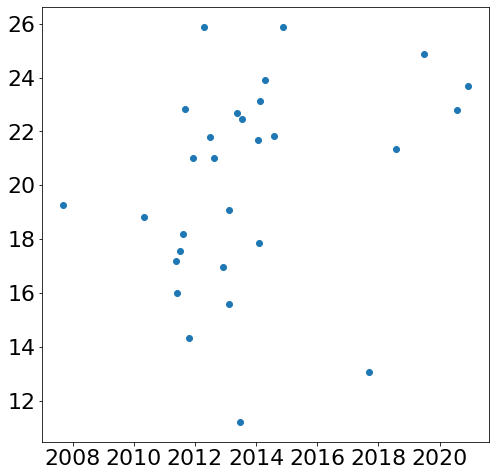

In [46]:
plt.figure(figsize=(8,8))

plt.scatter(date_MA.keys(), date_MA.values())